# Cell 1: Imports and Data Load

In [1]:
import pandas as pd
import numpy as np
import os

# Paths
data_dir = os.path.join('..', 'data')
processed_dir = os.path.join(data_dir, 'processed')
cleaned_path = os.path.join(processed_dir, 'cleaned_data.csv')
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

# Load cleaned data
df = pd.read_csv(cleaned_path)
print(f"Loaded data: {df.shape}")


Loaded data: (212, 18)


In [2]:
from sklearn.model_selection import train_test_split

# Features and target (exclude non-numeric/categorical columns)
feature_cols = [
    "Warning Level", "Level_Entries", "Streamflow_Entries", "Source Catchment Area",
    "Catchment Area", "Area variation (%)"
]
target_col = "Danger Level"

# Remove rows with missing values in features/target
data = df[feature_cols + [target_col]].dropna()
X = data[feature_cols]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (169, 6), Test shape: (43, 6)


# Cell 3: Train and Save All Models

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import joblib

models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
    "MLP": MLPRegressor(random_state=42, max_iter=500)
}

trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    # Save model
    model_path = os.path.join(models_dir, f"{name}_model.joblib")
    joblib.dump(model, model_path)
    print(f"{name} model saved to {model_path}")


Training RandomForest...
RandomForest model saved to ..\models\RandomForest_model.joblib
Training XGBoost...
XGBoost model saved to ..\models\XGBoost_model.joblib
Training SVR...
SVR model saved to ..\models\SVR_model.joblib
Training MLP...
MLP model saved to ..\models\MLP_model.joblib


# Cell 4: Evaluate Models

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = {}
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

results_df = pd.DataFrame(results).T
display(results_df)


RandomForest: RMSE=25.9315, MAE=7.1332, R2=0.9857
XGBoost: RMSE=14.1265, MAE=5.6623, R2=0.9957
SVR: RMSE=227.0700, MAE=165.3508, R2=-0.0993
MLP: RMSE=4405.1643, MAE=2640.6808, R2=-412.7332


,RMSE,MAE,R2
RandomForest,25.931485,7.133223,0.985663
XGBoost,14.126503,5.662340,0.995745
SVR,227.069961,165.350848,-0.099298
MLP,4405.164299,2640.680836,-412.733199


# Cell 5: (Optional) Save Test Predictions for Best Model

In [5]:
# Pick the best model (lowest RMSE)
best_model_name = results_df['RMSE'].idxmin()
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test)

preds_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_best
})
preds_df.to_csv(os.path.join(data_dir, "outputs", f"test_predictions_{best_model_name}.csv"), index=False)
print(f"Test predictions for {best_model_name} saved.")


Test predictions for XGBoost saved.


# Cell 5: SHAP Explainability

SHAP summary for RandomForest


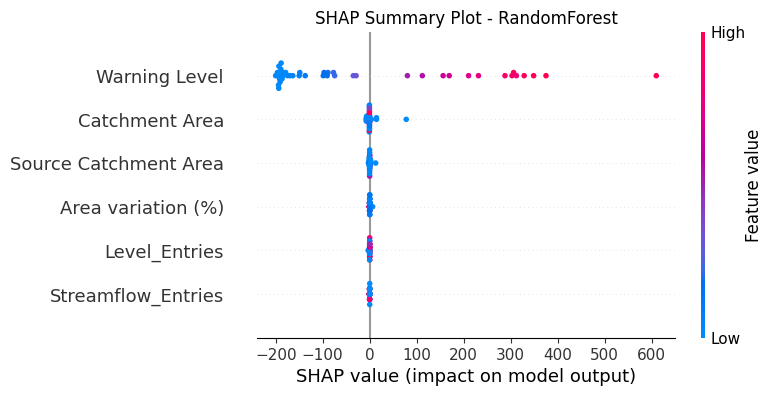

SHAP summary for XGBoost


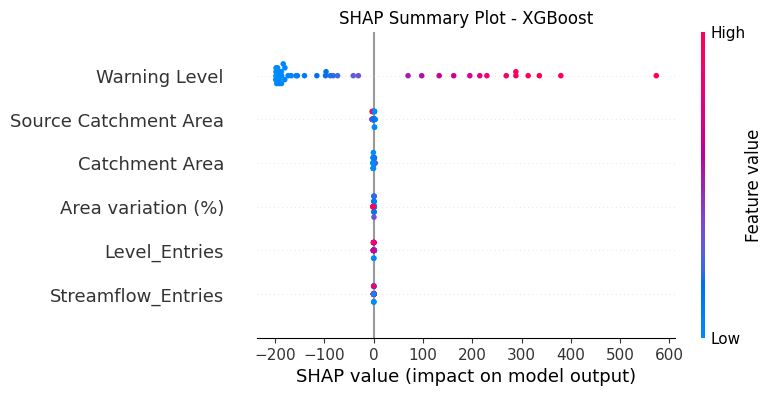

SHAP summary for SVR


ExactExplainer explainer: 44it [00:25,  1.71it/s]                        


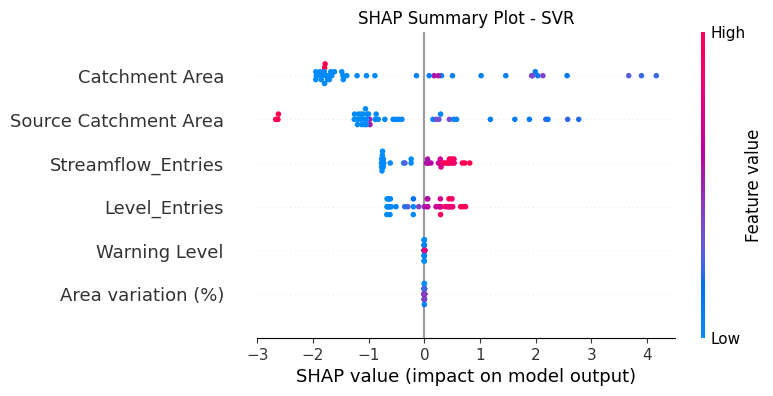

SHAP summary for MLP


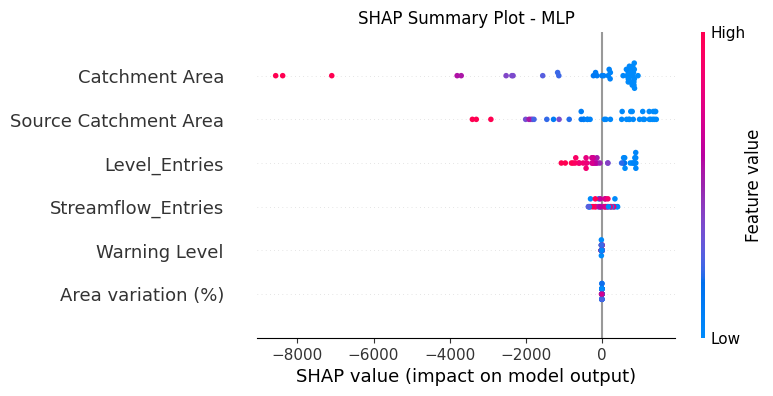

In [10]:
import shap
import matplotlib.pyplot as plt

# If you haven't already, fit all models on the full training data
for name, model in models.items():
    print(f"SHAP summary for {name}")
    model.fit(X_train, y_train)
    try:
        # Use TreeExplainer for tree-based models, KernelExplainer otherwise
        if name in ["RandomForest", "XGBoost"]:
            explainer = shap.Explainer(model, X_train)
            shap_values = explainer(X_test)
        else:
            # For SVR and MLP, use KernelExplainer (model-agnostic)
            # KernelExplainer can be slow; use a sample of the data
            background = shap.maskers.Independent(X_train, max_samples=100)
            explainer = shap.Explainer(model.predict, background)
            shap_values = explainer(X_test[:100])  # Use a subset for speed

        shap.summary_plot(shap_values, X_test, show=False)
        plt.title(f"SHAP Summary Plot - {name}")
        plt.show()
    except Exception as e:
        print(f"Could not compute SHAP for {name}: {e}")


# Cell 6: Save Model and Outputs

In [11]:
import joblib
import os
import pandas as pd

# Ensure outputs directory exists
outputs_dir = os.path.join(data_dir, "outputs")
os.makedirs(outputs_dir, exist_ok=True)

for name, model in trained_models.items():
    # Save model
    model_path = os.path.join(models_dir, f"{name}_model.joblib")
    joblib.dump(model, model_path)
    print(f"{name} model saved to {model_path}")

    # Predict and save predictions
    y_pred = model.predict(X_test)
    preds_df = pd.DataFrame({
        "Actual": y_test.values,
        "Predicted": y_pred
    })
    preds_csv_path = os.path.join(outputs_dir, f"test_predictions_{name}.csv")
    preds_df.to_csv(preds_csv_path, index=False)
    print(f"Predictions saved to {preds_csv_path}")


RandomForest model saved to ..\models\RandomForest_model.joblib
Predictions saved to ..\data\outputs\test_predictions_RandomForest.csv
XGBoost model saved to ..\models\XGBoost_model.joblib
Predictions saved to ..\data\outputs\test_predictions_XGBoost.csv
SVR model saved to ..\models\SVR_model.joblib
Predictions saved to ..\data\outputs\test_predictions_SVR.csv
MLP model saved to ..\models\MLP_model.joblib
Predictions saved to ..\data\outputs\test_predictions_MLP.csv
